### SVM classification, example 2, Heart disease prediction, data

**Let's try to find optimal parameters with RandomizedSearchCV!**

RandomizedSearchCV is much faster, but you need to get lucky in order to get good parameters!

This version attempts optimizing LinearSVC.

In [22]:
# usual imports in a classic ML pipeline for Classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# additional metrics ONLY for classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# import helpful features like pipelines etc, also SVM!
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [23]:
# load the data
df = pd.read_csv("Heart_Disease_Prediction.csv")


# let's quickly see the first 5 rows of data
df

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,52,1,3,172,199,1,0,162,0,0.5,1,0,7,Absence
266,44,1,2,120,263,0,0,173,0,0.0,1,0,7,Absence
267,56,0,2,140,294,0,2,153,0,1.3,2,0,3,Absence
268,57,1,4,140,192,0,0,148,0,0.4,2,0,6,Absence


In [24]:
# this is a binary variable, need to convert to integers laters
df['Heart Disease'].value_counts()

Heart Disease
Absence     150
Presence    120
Name: count, dtype: int64

In [25]:
# check duplicates 
df.duplicated().sum()

np.int64(0)

In [26]:
df.isna().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

**Step 2: handle categoricals**

We only have one binary variable, so we don't need to process other types of categoricals.

NOTE: this is actually also the target variable

For target variable, it's allowed to use values like 1,2,3,4 etc.
Even if they seem "nominal", since logistic regression only works with one ouput by default.

In [27]:
# you can also use LabelEncoder here, but you have more 
# control on what is what if you use mapping
target_mapping = {"Absence": 0, "Presence": 1}
df['Heart Disease'] = df['Heart Disease'].map(target_mapping)

**There's no ordinal or nominal categories here, we can proceed to X/y -phase**

In [28]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


### X/y and train/test -splits

In [29]:
# first step, we split our data into SUPPORT variables and the TARGET variable
# X => support variables, y => target variable

# X => list of support variables the model uses 
# while predicting the target variable with the model
X = df.drop("Heart Disease", axis=1)

# our target variable is y
y = df["Heart Disease"]

**IMPORTANT WHEN OPTIMIZING PARAMETERS!**

Always lock down randomness in your algorithm and data so that your baseline remains the same. If you don't do this, you never know if the model improved because of the parameters or just sheer luck!

Here we only lock down train/test-split. We usually also lock down NumPy random seed + others!

In [30]:
# secondly, train/test -split with scikit-learn's helper function
# 0.3 for testing => 30% of data is reserved for testing purposes
# and based on that => it's deduced that 70% will be in the training data

# you can also define the random state, which is sometimes useful
# if you want to "lock down" all the randomness in order to get same results every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=91875)

### RandomizedSearchCV, let's try optimizing SVC

RandomizedSearchCV is based on a more exploration -oriented parameter search.

In this case we have 4x more fits in the search too than in the GridSearchCV -version.

**Idea to improve this:** use a Pipeline also here in the RandomizedSearchCV in order to have the same situation here as in the actual model training.

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from scipy.stats import uniform
from sklearn.calibration import CalibratedClassifierCV

# initialize testable parameters
# Since we have to wrap LinearSVC into CalibratedClassifierCV
# we have to use this estimator__ prefix in the parameters
param_dist = {
    'estimator__C': [0.75, 0.85, 0.9, 1, 1.25, 1.35, 1.45, 1.5],
    'estimator__loss': ['hinge', 'square_hinge'],
    'estimator__tol': [0.001, 0.0001, 0.002, 0.0025, 0.00125]
}

# start finding the optimal parameters with RandomizedSearchCV!
# RandomizedSearchCV is usually way faster than GridSearchCV
# .... but it's also mostly random
test_model = RandomizedSearchCV(CalibratedClassifierCV(svm.LinearSVC()), param_dist, n_iter=1200, verbose=3, n_jobs=-1, cv=5, random_state=42)
test_model.fit(X_train, y_train)

c:\Users\tuomas.valtanen\introtoml2026lectures\IntroductionToML2026\.venv\Lib\site-packages\sklearn\model_selection\_search.py:324: UserWarning: The total space of parameters 80 is smaller than n_iter=1200. Running 80 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\Users\tuomas.valtanen\introtoml2026lectures\IntroductionToML2026\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:490: FitFailedWarning: 
200 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
89 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\tuomas.valtanen\introtoml2026lectures\IntroductionToML2026\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tuomas.valtanen\introtoml2026lectures\IntroductionToML2026\.venv\Lib\site-packages\sklearn\base.py", line 1336, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",CalibratedCla...r=LinearSVC())
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'estimator__C': [0.75, 0.85, ...], 'estimator__loss': ['hinge', 'square_hinge'], 'estimator__tol': [0.001, 0.0001, ...]}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",1200
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versioncha

In [32]:
# let's see the optimal parameters based on GridSearchCV above
test_model.best_params_

{'estimator__tol': 0.0025, 'estimator__loss': 'hinge', 'estimator__C': 0.75}

### Train the SVC model

In [33]:
# create the model and train it with the data

# if you wish to use LinearSVC => we need to wrap it into a
# CalibratedClassifierCV so it outputs probabilities for the metrics
# model = make_pipeline(StandardScaler(), CalibratedClassifierCV(svm.LinearSVC()))

# Pipeline is super helpful here, since we can integrate the scaler
# before the model, no need to manually scale anything
model = make_pipeline(StandardScaler(), CalibratedClassifierCV(svm.LinearSVC(C=0.85, tol=0.00125, loss="hinge")))
model.fit(X_train, y_train)

c:\Users\tuomas.valtanen\introtoml2026lectures\IntroductionToML2026\.venv\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('calibratedclassifiercv', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2","LinearSVC(C=0..., tol=0.00125)"
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, c

### Classification error metrics

In [34]:
# we need to create test predictions based on our earlier reserved test dataset
# this data has never been seen by the model by now
predictions = model.predict(X_test)

In [35]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# NICE RESULT!

              precision    recall  f1-score   support

           0       0.83      0.94      0.88        47
           1       0.89      0.74      0.81        34

    accuracy                           0.85        81
   macro avg       0.86      0.84      0.84        81
weighted avg       0.86      0.85      0.85        81


Model overall accuracy: 85.19%


<Axes: >

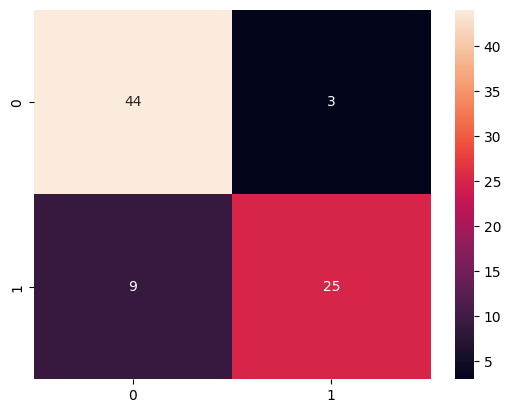

In [36]:
# see the confusion matrix
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')


In [37]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means you could get the same result with just random guessing
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9042553191489362

### Using the model in practice

In [38]:
df.columns

Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
       'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
       'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
      dtype='str')

In [39]:
df['EKG results'].value_counts()

EKG results
2    137
0    131
1      2
Name: count, dtype: int64

In [40]:
df.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


In [41]:
# usually in GUI application we save the model-object / variable into a file (by using joblib-module)
# and in the GUI application => we load the saved model from the file
# and use the model just like here below


# map all the variables from the user
# into a Python dictionary
# the variable names have to match with the original dataset
tester_row = {
    'Age': 36, 
    'Sex': 0, 
    'Chest pain type': 4, 
    'BP': 120, 
    'Cholesterol': 500, 
    'FBS over 120': 0,
    'EKG results': 1, 
    'Max HR': 140, 
    'Exercise angina': 1, 
    'ST depression': 1,
    'Slope of ST': 2, 
    'Number of vessels fluro': 3, 
    'Thallium': 7
}

# convert to pandas format
tester_row = pd.DataFrame([tester_row])


In [42]:
print("All probabilities by category:")
print(model.predict_proba(tester_row))
print()

# change these based on your original data
labels = ["No", "Yes"]

print("Does this person have the heart disease (Yes/No):")
result = labels[model.predict(tester_row)[0]]
print(result)
print("-------------------")

All probabilities by category:
[[0.01562283 0.98437717]]

Does this person have the heart disease (Yes/No):
Yes
-------------------
